# Run Pharaglow 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import shutil
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features, util

### input parameters

In [2]:
### CHANGE FILE/DIRECTORY NAMES
# parameterfile = "../AnalysisParameters_1x"
# inPath = "/home/mscholz/Dropbox (Scholz Lab)/Shared/Data/MS0006_0_1000frames"
# outPath = "/home/mscholz/Desktop/TestOutput_MS0006/"
# lawnPath = None #"/opt/data/Lawns/"
# movie = "MS0006_0_1000frames"
# nWorkers = 5

parameterfile = '/home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/Linking/EB0068_parameters.txt'
inPath = '/home/nif/Desktop/data/Elsa/1_Rawdata/20201217_solenoid_mutants/recording/EB0068c/'
outPath = f'/home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/test'
lawnPath = None #"/opt/data/Lawns/"
movie = "EB0068"
nWorkers = 20

### Load data and create binary masks 

In [3]:
%%time

movieID = movie[-6:]
if lawnPath is not None and lawnPath != 'None':
    try:
        lawnfile = os.path.join(lawnPath,movieID+'_lawn.tiff')
        lawn = pims.open(lawnfile)[0]
        binLawn = features.findLawn(lawn)
    except Exception:
        lawnfile = os.path.join(lawnPath,movieID+'_lawn.bmp')
        lawn = pims.open(lawnfile)[0]
        binLawn = features.findLawn(lawn)
else:
    lawnfile = None


# creating new file names
fname = os.path.join(inPath,"*.tiff")
outfile = os.path.join(outPath, movieID+"_{}_{}.json")
print(outfile)
saveparam = os.path.join(outPath, movieID+"_parameters")
print(saveparam)

# starting pharaglow
print('Starting pharaglow analysis...')
rawframes = pims.open(fname)
rawframes = rawframes
# rawframes = rawframes[:300]
print('Loading parameters from {}'.format(parameterfile.split('/')[-2:]))
with open(parameterfile) as f:
    param = json.load(f)
    

/home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/test/EB0068_{}_{}.json
/home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/test/EB0068_parameters
Starting pharaglow analysis...
Loading parameters from ['Linking', 'EB0068_parameters.txt']
CPU times: user 452 ms, sys: 47 ms, total: 499 ms
Wall time: 498 ms


### Improve lawn detection if neccessary

In [4]:
if lawnfile is not None:
    from skimage.filters import threshold_li, gaussian, threshold_yen, threshold_otsu
    from skimage.morphology import skeletonize, watershed, disk, remove_small_holes, remove_small_objects
    image = gaussian(lawn, 1, preserve_range = True)
    thresh = threshold_li(image, initial_guess = np.median)
    binary = image > thresh*0.5
    binary = remove_small_holes(binary, area_threshold=1500, connectivity=1, in_place=False)
    binary = remove_small_objects(binary, min_size=5000, connectivity=8, in_place=False)
    binLawn = binary
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(lawn)
    plt.contour(binLawn, alpha=0.5, cmap='pink')
    plt.subplot(122)
    plt.imshow(binLawn)

### Create binary masks

In [5]:
%%time
# detecting objects
print('Binarizing images')
masks = tracking.calculateMask(rawframes, minSize = param['minSize'], bgWindow = param['bgWindow']
                               , thresholdWindow = param['thresholdWindow'], smooth =  param['smooth'],
                               subtract =  param['subtract'], dilate = param['dilate'] , tfactor=param['tfactor'])


Binarizing images
CPU times: user 23 s, sys: 1.34 s, total: 24.4 s
Wall time: 24.4 s


### Make sure the thresholding worked otherwise change parameters

In [6]:
# Select a rawframe to visualize
t = 300
print(f"rawframe {t} to visualize ")

if t> (len(rawframes)-1):
    print(f"Warning ! Max {len(rawframes)-1} rawframes. {t} changed to 0")
    t=0

rawframe 300 to visualize 


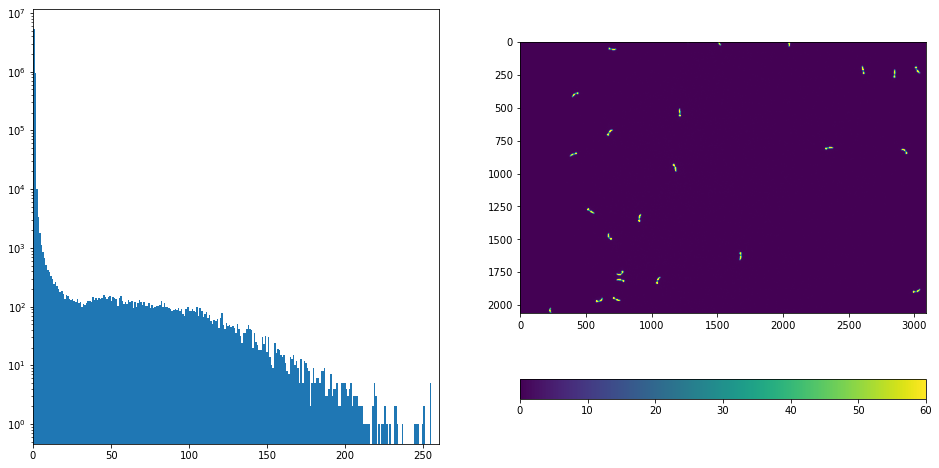

In [7]:
plt.figure(figsize=(16,8))

plt.subplot(121)
# Plot the histogram of the pixel intensity values of the rawframe
plt.hist(rawframes[t].ravel(), bins=256, log=True)
plt.xlim(0, 260) # xlim for 8 bits image

plt.subplot(122)
# Adjust the color limit for the rawframe for vizualisation only
color = (0,60) # 0<=color<=255 for 8 bits image
# color = None 
plt.imshow(rawframes[t],clim = color)
plt.colorbar(orientation='horizontal')


False


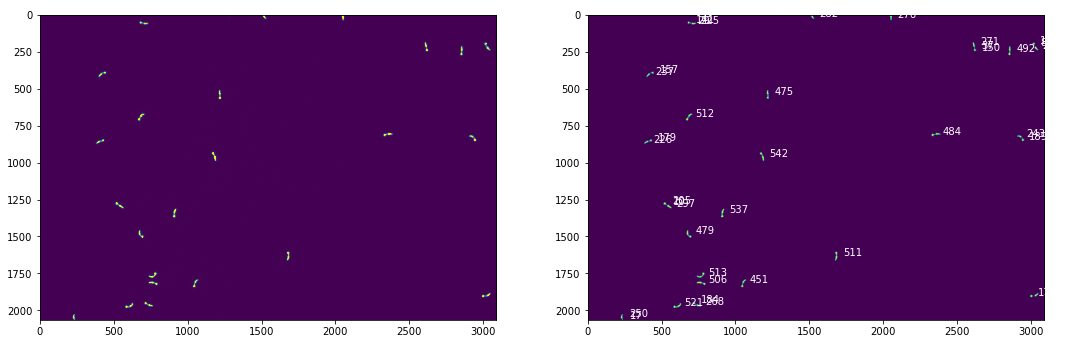

In [8]:
from skimage.measure import label, regionprops

plt.figure(figsize=(18,16))

plt.subplot(121)
# Show the rawframe
plt.imshow(rawframes[t],clim= color)#+lawn)
if lawnfile is not None:
    # Show the lawn
    plt.contour(binLawn, alpha=0.5, cmap='pink')
    
plt.subplot(122)
# Show the masks and their size [px]
plt.imshow(masks[t])#[:600,1000:])#[500:1500,2000:3500])#[:,2500:])
print(np.min(masks[t]))
label_image = label(masks[t], background=0, connectivity = 1)
for region in regionprops(label_image):
    plt.text(region.centroid[1]+50, region.centroid[0], region.area, color ='w')


### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [9]:
import time
from multiprocessing import Pool

chunksize = 100#
def parallelDetection(rawframes, masks, nWorkers):
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
   
    #slice the movie into pieces to run
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+chunksize+1, chunksize)))
    jobs = []
    for (a,b) in slices:
        jobs.append([rawframes[a:b+1], masks[a:b+1], param, a])
    # delete jobs of length 1
    jobs = [j for j in jobs if len(j[0])>1]
    #run the parallel feature detection.
    features = []
    images = []
    p = Pool(processes = nWorkers)
    start = time.time()
    for k, res in enumerate(p.imap_unordered(tracking.parallelWorker, jobs)):
        features.append(res[0])
        images.append(res[1])
        if k == nWorkers:
            print('Expected time is approx. {} s'.format((L/chunksize-k)*(time.time()-start)/nWorkers))
    
    p.close()
    p.join()
    features = pd.concat(features)
    images = pd.concat(images)
    # make one big dataframe
    features = pd.concat([features, images], axis = 1)
    return features

In [10]:
%%time

print('Detecting features')
if nWorkers ==1 or len(rawframes) < chunksize:
    features, images = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
    features = pd.concat([features, images], axis = 1)
else:
    features = parallelDetection(rawframes, masks, nWorkers)

Detecting features
Analyzing frames 0 to 101
Analyzing frames 100 to 201
Analyzing frames 200 to 301
Analyzing frames 300 to 401
Analyzing frames 400 to 501
Analyzing frames 500 to 601
Analyzing frames 600 to 701
Analyzing frames 700 to 801
Analyzing frames 800 to 901
Analyzing frames 900 to 1001
Analyzing frames 1000 to 1101
Analyzing frames 1100 to 1201
Analyzing frames 1200 to 1301
Analyzing frames 1300 to 1401
Analyzing frames 1400 to 1501
Analyzing frames 1500 to 1601
Analyzing frames 1600 to 1701
Analyzing frames 1700 to 1801
Analyzing frames 1800 to 1901
Analyzing frames 1900 to 2001
Analyzing frames 2000 to 2101
Expected time is approx. 4479.6712718162535 s
Analyzing frames 2100 to 2201
Analyzing frames 2200 to 2301
Analyzing frames 2300 to 2401
Analyzing frames 2400 to 2501
Analyzing frames 2500 to 2601
Analyzing frames 2600 to 2701
Analyzing frames 2700 to 2801
Analyzing frames 2800 to 2901
Analyzing frames 2900 to 3001
Analyzing frames 3000 to 3101
Analyzing frames 3100 to 3

Analyzing frames 26000 to 26101
Analyzing frames 26100 to 26201
Analyzing frames 26200 to 26301
Analyzing frames 26300 to 26401
Analyzing frames 26400 to 26501
Analyzing frames 26500 to 26601
Analyzing frames 26600 to 26701
Analyzing frames 26700 to 26801
Analyzing frames 26800 to 26901
Analyzing frames 26900 to 27001
CPU times: user 1h 5min 12s, sys: 3min 27s, total: 1h 8min 40s
Wall time: 1h 11min 22s


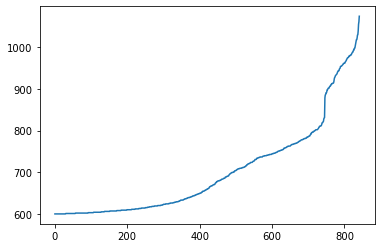

In [11]:
### Show the area of all objects
plt.plot(np.sort(features['area'].values))

### Save features

In [12]:
# # trajectories
features.head(5)
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all_2.0'), orient='split')

# saving parameter file
shutil.copyfile(parameterfile, saveparam, follow_symlinks=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842 entries, 0 to 0
Columns: 9282 entries, y to 9269
dtypes: float64(7402), int64(1880)
memory usage: 59.6 MB


'/home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/test/EB0068_parameters'

### Load all features

In [13]:
features = pd.read_json(outfile.format('features', 'all_2.0'), orient='split')

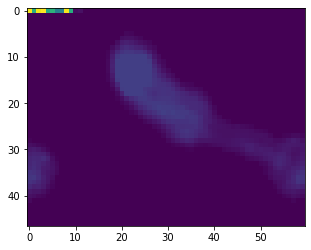

In [15]:
### test the new image storageq
N=1
tim = util.get_im(features.iloc[N], int(features.iloc[N]['shapeX']), int(features.iloc[N]['shapeY']))

plt.imshow(tim)

### Link objects to trajectories and interpolate short misses

In [16]:
print('Done')
print('Linking trajectories')
#pred = tp.predict.NearestVelocityPredict()
#trajectories = pred.link_df(features,param['searchRange'], memory = param['memory'])
trajectories = tp.link_df(features,param['searchRange'], memory = param['memory'])

Frame 25988: 1 trajectories present.


In [17]:
print('Interpolating trajectories')
traj = []
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    # make new columns for the offset
    traj.append(tracking.interpolateTrajectories(tmp))
trajectories = pd.concat(traj, ignore_index = True)
trajectories['shapeX'] = trajectories['shapeX'].astype(int)
trajectories['shapeY'] = trajectories['shapeY'].astype(int)

Interpolating trajectories


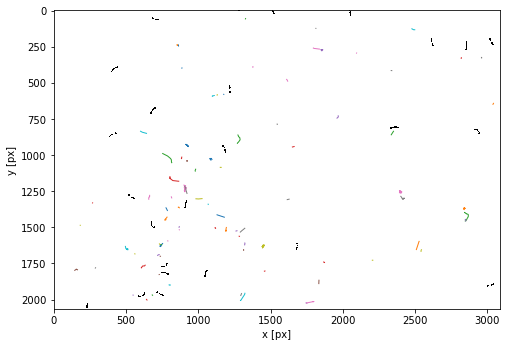

In [18]:
plt.figure(figsize=(8,8))
tp.plot_traj(trajectories, superimpose=1-masks[t]);

In [19]:
print(trajectories['particle'].nunique())
trajectories = tp.filter_stubs(trajectories,param['minimalDuration'])
print(trajectories['particle'].nunique())

119
0


ValueError: DataFrame of trajectories is empty.

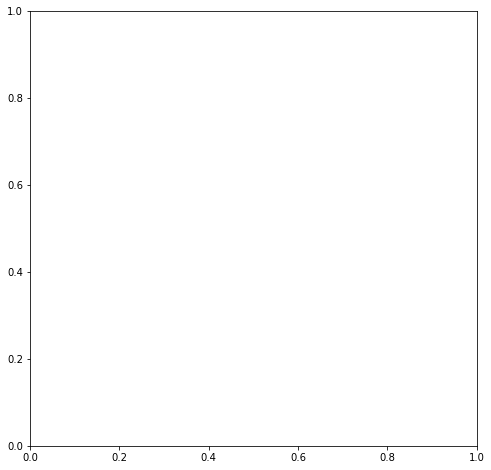

In [20]:
plt.figure(figsize=(8,8))
tp.plot_traj(trajectories, superimpose=1-masks[t]);

### add the missing images to interpolated trajectories

In [ ]:
%%time
print('Fill in missing images')
from pharaglow import tracking, run, features
# interpolate the shape parameter
def interpolate_helper(rawframes, row):
    """wrapper to make the code more readable."""
    # check if image is nan - then we insert an image from the original movie
    im_cols =  range(int(row['shapeX']*row['shapeY']))
    
    if np.any(np.isnan(row[im_cols])):
        print('interpolating', row['frame'])
        im, sx0,sx1,sy0, sy1, ly, lx = tracking.fillMissingImages(rawframes, int(row['frame']), row['x'], row['y'],\
                                                   lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])
        # make the image into a pandas format and return a whole row
        im_cols =list(range(ly*lx))
        # other column names
        [im_cols.append(x) for x in ['slice_x0','slice_x1','slice_y0','slice_y1', 'shapeY', 'shapeX']]
        row[im_cols] = [*list(im.ravel()),  sx0,sx1,sy0, sy1, ly, lx]
    return row


trajectories = trajectories.apply(\
       lambda row: interpolate_helper(rawframes, row), axis=1)


### Extract lawn info

In [ ]:
%%time

def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawnfile is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

### Show resulting trajectories

In [ ]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories, superimpose=1-masks[t]);

In [ ]:
# # write trajectories to separate files.
#trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    
    # write trajectories to file
    tmp.to_json(outfile.format('trajectories_new', int(particle_index)), orient='split')

### check slow-down before continuing analysis

In [ ]:
if lawnfile is not None:
    plt.figure(figsize=(12,8))
    vcut = []
    dt = 1000
    for pid in trajectories['particle'].unique():
        tmp = trajectories[['frame', 'x', 'y']][trajectories.loc[:,'particle'] == pid].diff()
        f = (trajectories[['inside']][trajectories.loc[:,'particle'] == pid]).mean().values
        if f<0.9 and f>0.01:
            t0 = np.where((trajectories[['inside']][trajectories.loc[:,'particle'] == pid])==1)[0][0]
            print('t0:', t0)
            try:
                if t0>dt:
                    print('pid:', pid)
                    time = np.linspace(0,2*dt/30., 2*dt)
                    #print('time:', len(time))
                    v = np.sqrt((tmp['x']**2+tmp['y']**2))/tmp['frame']*30*2.4
                    #print('v:', v)
                    #print('v.iloc:', v.iloc[t0-dt:t0+dt])
                    plt.plot(time, v.iloc[t0-dt:t0+dt], 'navy', alpha=0.1)
                    vcut.append(v.iloc[t0-dt:t0+dt].values)
                else:
                    print('trajectory is too short')
            except ValueError:
                print('t0-dt or t0+dt exceeds number of frames')
                continue
                    
    if len(vcut) >0:  
        plt.plot(time, np.mean(np.array(vcut), axis=0), color='navy')
        plt.plot(time, util.smooth(np.mean(np.array(vcut), axis=0), 30), color='r')
        plt.axvline(dt/30, color='k', linestyle='--')
        plt.ylabel(r"velocity ($\mu$m/s)");
        plt.xlabel("time (s)");
        plt.ylim(0,150)

### run the whole pharaglow feature extraction

In [ ]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores)
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

#### run this if acidentally used an odd length like an idiot.

In [ ]:
def padIm(im, size = 22500):
    return np.pad(im, (0,size-len(im)), mode='constant', constant_values=0)

def fixImages(trajectories):
    trajectories[['image']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['image'], row['shapeX']*row['shapeY'])) if len(row['image'])<row['shapeX']*row['shapeY'] else row['image'], axis=1)
    trajectories[['diffI']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['diffI'], row['shapeX']*row['shapeY'])) if len(row['diffI'])<row['shapeX']*row['shapeY'] else row['diffI'], axis=1)


### Save data as json format (every trajectory in a file)

In [ ]:
%%time
import os
# save only minimal outputs - reduces save by approx factor 3
save_minimal = False
path = os.path.dirname(outfile)
for fn in os.listdir(path):
    file = os.path.join(path,fn)
    print(fn)
    if os.path.isfile(file) and f'{movieID}_trajectories_' in fn and fn.endswith('.json'):
        print(fn)
        particle_index = int(fn.split('.')[0].split('_')[-1])
        traj =  pd.read_json(file, orient='split')
        # check if the images are non-zero
        # get all images
        traj['image'] = traj.apply(lambda row: util.get_im(row, int(row['shapeX']), int(row['shapeY'])), axis=1)
        if not np.all(np.array([np.sum(im) for im in traj['image']])>0):
            continue
            
        traj['shapeX'] = traj['shapeX'].astype(int)
        print('Analyzing trajectory:', fn)
        
        #tmp = run.runPharaglowOnStack(traj, param)
        tmp = parallelize_dataframe(traj, run.runPharaglowOnStack, n_cores = nWorkers, params = param)
        # get more exact entry location
        if lawnfile is not None:
            tmp['insideHead'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], binLawn)), axis=1)
            tmp['insideHeadIntensity'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], lawn)), axis=1)
        if save_minimal:
            tmp = tmp.drop(['Mask', 'SkeletonX', 'SkeletonY', 'ParX', 'ParY', 
                        'Xstart', 'Xend', 'Centerline', 'dCl', 'Widths', 'Contour', 'Gradient', 
                        'Kymo', 'KymoGrad', 'Similarity', 'Xtmp'], axis = 1)
        tmp = tmp.drop(['image'], axis = 1)
        # remove some columns to make the result smaller
        tmp.to_json(outfile.format('results', particle_index), orient='split')
        